<a href="https://colab.research.google.com/github/tdandujar/Problema-de-las-hormigas-con-Python/blob/master/PROYECTO_%7C_SISTEMA_DE_RECOMENDACI%C3%93N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROYECTO | SISTEMA DE RECOMENDACIÓN**

**IMPORTANDO LIBRERÍAS**





In [6]:
from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.integrate as integrate

import torch
import torch.nn as nn
import torch.nn.functional as F

**ENLACE DE DATASET | DRIVE**

In [9]:
!gdown https://drive.google.com/file/d/12Et3wzxCSCwpG33zabg_v66hh1_5vjel/view?usp=sharing

/usr/local/lib/python3.9/dist-packages/gdown/parse_url.py:35: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=12Et3wzxCSCwpG33zabg_v66hh1_5vjel
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/12Et3wzxCSCwpG33zabg_v66hh1_5vjel/view?usp=sharing
To: /content/view?usp=sharing
72.6kB [00:00, 49.6MB/s]


In [10]:
!gdown https://drive.google.com/file/d/1X15mU6UYQin44PRn4Pqx0TKD82ELfXlt/view?usp=share_link

/usr/local/lib/python3.9/dist-packages/gdown/parse_url.py:35: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1X15mU6UYQin44PRn4Pqx0TKD82ELfXlt
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1X15mU6UYQin44PRn4Pqx0TKD82ELfXlt/view?usp=share_link
To: /content/view?usp=share_link
72.7kB [00:00, 38.0MB/s]


**RECOLECTAR** **DATOS** | **DATASET CRUDO** 

In [11]:
data = pd.read_csv("movies.csv")
print("Número de puntos de datos: ", len(data))
data = data.head(5000)
data.head()

Número de puntos de datos:  62423


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
data = pd.read_csv("ratings.csv")
print("Número de puntos de datos: ", len(data))
data = data.head(5000)
data.head()

Número de puntos de datos:  209847


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


data = pd.read_csv("ratings.csv")
print("Número de puntos de datos: ", len(data))
data = data.head(5000)
data.head()

In [14]:
data = data[['userId','movieId', 'rating']] #Eliminando columna 'timestamp' y creando diccionario 
data

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5
...,...,...,...
4995,32,595,3.0
4996,33,50,3.5
4997,33,110,4.0
4998,33,296,4.5


In [15]:
data.dtypes

userId       int64
movieId      int64
rating     float64
dtype: object

In [16]:
data.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [17]:
data['rating'].value_counts()

4.0    1392
3.0     892
5.0     768
3.5     615
2.0     384
4.5     368
2.5     306
1.0     114
1.5     108
0.5      53
Name: rating, dtype: int64

**ANÁLISIS EDA | DATOS**

In [18]:
sns.set(rc={'figure.figsize':(9.7,5.2)}) #Le da formato a los gráficos 

Text(0.5, 0, 'movieId')

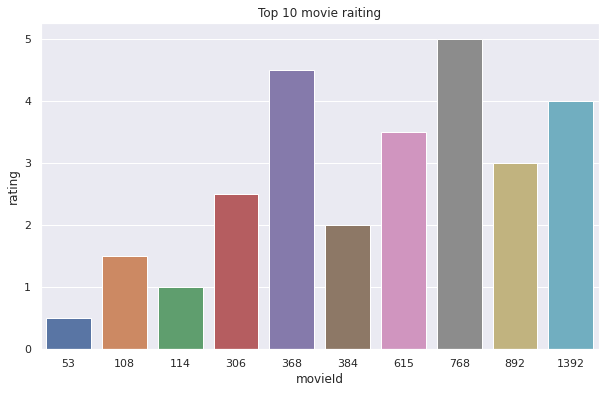

In [130]:
top_movie_rating = data['rating'].value_counts()
movie_rating = data['movieId'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x = top_movie_rating, y = top_movie_rating.index)
plt.ylabel('rating')
plt.title('Top 10 movie raiting')
plt.xlabel('movieId')

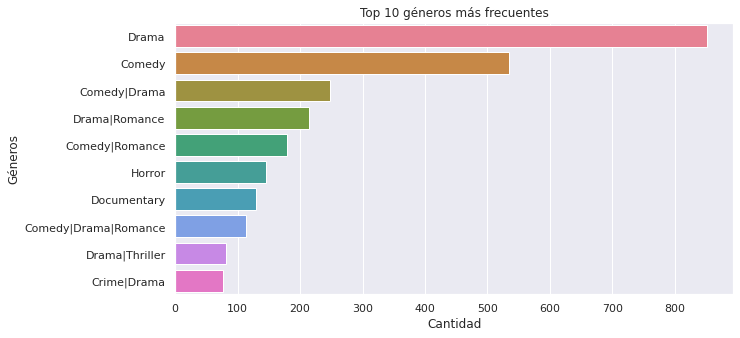

In [133]:
top_ten = data['genres'].value_counts().nlargest(10)
colors = sns.color_palette("husl", len(top_ten))
plt.figure(figsize=(10,5))
ax = sns.barplot(x=top_ten.values, y=top_ten.index, palette=colors)    
plt.title("Top 10 géneros más frecuentes")  
plt.xlabel("Cantidad")
plt.ylabel("Géneros")
plt.show()

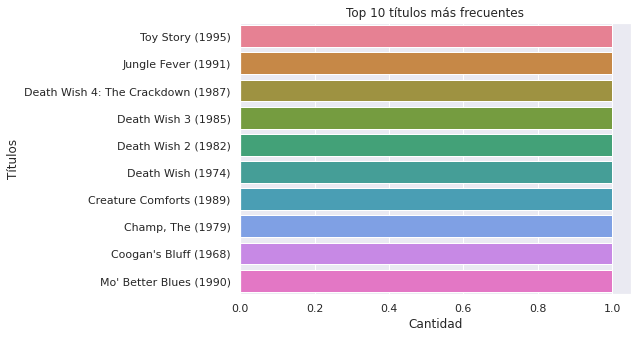

In [134]:
colors = sns.color_palette("husl", len(top_ten))
top_ten = data['title'].value_counts().nlargest(10)
plt.figure(figsize=(7,5))
ax = sns.barplot(x=top_ten.values, y=top_ten.index, palette=colors)
plt.title("Top 10 títulos más frecuentes")  
plt.xlabel("Cantidad")
plt.ylabel("Títulos")
plt.show()

<Axes: ylabel='userId'>

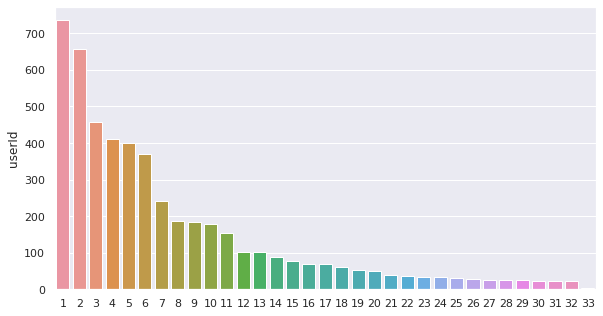

In [137]:
sns.barplot(x=data['userId'].unique(), y=data['userId'].value_counts()) 

<Axes: xlabel='rating', ylabel='Count'>

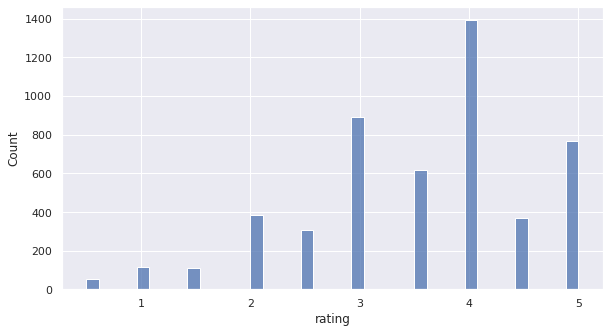

In [138]:
sns.histplot(data=data, x='rating')

# Nueva sección

**PROCESAMIENTO DE LA** **DATA PARA ENTRENAMIENTO Y VALIDACIÓN**

In [19]:
# split train and validation before encoding 
np.random.seed(3)
msk = np.random.rand(len(data)) < 0.8
train = data[msk].copy()
val = data[~msk].copy()
val.shape, train.shape

((998, 3), (4002, 3))

In [20]:
# here is a handy function modified from fast.ai
def proc_col(col, train_col=None):
    """Encodes a pandas column with continous ids. 
    """
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)

In [21]:
def encode_data(df, train=None):
    """ Encodes rating data with continous user and movie ids. 
    If train is provided, encodes df with the same encoding as train.
    """
    df = df.copy()
    for col_name in ["userId", "movieId"]:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        _,col,_ = proc_col(df[col_name], train_col)
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df

**CODIFICACIÓN** **DEL MODELO**

In [22]:
train_e = encode_data(train)
val_e = encode_data(val, train)
train_e.head()

,userId,movieId,rating
0,0,0,5.0
1,0,1,3.5
2,0,2,5.0
3,0,3,5.0
6,0,4,3.5


In [23]:
num_users = len(train_e.userId.unique())
num_items = len(train_e.movieId.unique())
f"Cantidad de usuarios: {num_users}",  f"Cantidad de películas: {num_items}"

('Cantidad de usuarios: 33', 'Cantidad de películas: 2119')

**EMBEDDING LAYER** |  **NEURAL NETWORK MODEL**

In [24]:
emb_size = 100
user_emb = nn.Embedding(num_users, emb_size)
item_emb = nn.Embedding(num_items, emb_size)
users = torch.LongTensor(train_e.userId.values)
items = torch.LongTensor(train_e.movieId.values)

In [25]:
# Note here there is no matrix multiplication, we could potentially make the embeddings of different sizes.
# Here we could get better results by keep playing with regularization.
    
class CollabFNet(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, n_hidden=10):
        super(CollabFNet, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.lin1 = nn.Linear(emb_size*2, n_hidden)
        self.lin2 = nn.Linear(n_hidden, 1)
        self.drop1 = nn.Dropout(0.1)
        
    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        x = F.relu(torch.cat([U, V], dim=1))
        x = self.drop1(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

In [26]:
def test_loss(model, unsqueeze=False):
    model.eval()
    users = torch.LongTensor(val_e.userId.values) #.cuda()
    items = torch.LongTensor(val_e.movieId.values) #.cuda()
    ratings = torch.FloatTensor(val_e.rating.values) #.cuda()
    if unsqueeze:
        ratings = ratings.unsqueeze(1)
    y_hat = model(users, items)
    loss = F.mse_loss(y_hat, ratings)
    print("test loss %.3f " % loss.item())

In [27]:
def train_epocs(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    for i in range(epochs):
        users = torch.LongTensor(train_e.userId.values) # .cuda()
        items = torch.LongTensor(train_e.movieId.values) #.cuda()
        ratings = torch.FloatTensor(train_e.rating.values) #.cuda()
        if unsqueeze:
            ratings = ratings.unsqueeze(1)
        y_hat = model(users, items)
        loss = F.mse_loss(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss.item()) 
    test_loss(model, unsqueeze)

In [28]:
model = CollabFNet(num_users, num_items, emb_size= emb_size) #.cuda()

**ENTRENAMIENTO DEL MODELO**

In [29]:
train_epocs(model, epochs=15, lr=0.05, wd=1e-6, unsqueeze=True) 

15.358195304870605
5.840059280395508
1.3320037126541138
5.9522385597229
3.3514134883880615
1.089376449584961
1.423183560371399
2.4129135608673096
2.818675994873047
2.4686942100524902
1.6375179290771484
0.8150059580802917
0.6292672753334045
1.2021846771240234
1.5995856523513794
test loss 1.643 


**MATRIX DE** **FACTORIZACIÓN**

In [30]:
x = model.user_emb(torch.LongTensor(train_e.userId.values))
y = model.item_emb(torch.LongTensor(train_e.movieId.values))
y_t = torch.transpose(y, 1, 0)

full_ratings = torch.matmul(x, y_t)

In [31]:
newDataRating = full_ratings.detach().numpy()
df_row = x.detach().numpy().flatten()
df_columns = y.detach().numpy().flatten()

**MATRIX DE** **FACTORIZACIÓN**

In [32]:
new_data = pd.DataFrame(newDataRating)

**LIMPIEZA DE MATRIZ DE FACTORIZACIÓN**, **ELIMINAR LOS VALORES DUPLICADOS**

In [33]:
new_data = new_data.drop_duplicates().reset_index(drop=True)
new_data

,0,1,2,3,4,5,6,7,8,9,...,3992,3993,3994,3995,3996,3997,3998,3999,4000,4001
0,15.680927,11.450949,10.349428,16.410227,13.432896,12.609638,10.053344,22.170794,9.852703,5.811156,...,7.458549,8.007429,9.513803,7.035700,6.665572,8.854700,16.093243,16.450167,15.680927,15.802759
1,4.939569,4.243597,12.031978,13.717658,-2.219971,-1.471229,2.770892,8.830091,3.298518,12.299750,...,0.677819,8.621057,6.389735,5.041620,0.847638,10.345984,3.497324,8.786830,4.939569,11.053916
2,9.315922,3.761742,-1.062995,2.714476,1.660065,15.266004,19.199190,9.796084,-4.241233,-2.901569,...,6.146491,10.293417,12.313919,11.680480,1.586652,6.811214,-1.536927,1.026037,9.315922,4.470535
3,10.951736,5.944872,12.845712,15.748284,8.683560,8.987642,5.486524,3.513586,-0.580610,3.977435,...,11.881583,-9.461058,-3.932882,1.151134,3.602754,0.927333,12.285357,0.284863,10.951736,-4.630239
4,10.323423,13.819119,11.766293,13.781752,-0.891147,-2.670471,7.382294,1.977913,3.254594,1.129241,...,4.954889,13.871805,6.087429,7.946890,9.491578,1.792351,12.462027,10.905216,10.323423,6.889501
5,9.268191,14.105034,20.826048,18.198984,2.763502,10.857656,16.370613,10.433661,7.647788,5.962169,...,17.727077,1.835202,2.789971,1.837578,19.932722,12.937549,11.543447,12.976798,9.268194,1.223183
6,10.056891,19.028530,19.811451,24.039532,0.753379,0.024402,10.257736,14.311014,-1.975335,11.857655,...,8.637486,4.988093,6.358401,3.527506,-1.824529,5.562104,6.070821,3.949589,10.056891,6.076990
7,2.000159,13.825461,14.154133,16.394276,3.898484,18.144859,15.888966,22.386496,2.710087,12.495565,...,11.534154,12.654733,4.350310,5.065464,16.062658,8.673612,9.988200,8.824371,2.000160,14.728915
8,6.567974,10.652977,10.134935,11.752109,-0.964631,15.111175,14.173306,19.950462,4.016824,4.120709,...,6.161710,7.973337,1.239120,-6.290610,14.207538,11.605322,-1.516564,5.893329,6.567974,13.713667
9,7.654477,3.452964,17.163385,8.189964,10.508945,12.144773,10.853207,5.956463,5.632102,7.092710,...,3.416550,12.844614,12.199365,8.275753,6.860253,6.715159,2.125172,1.681823,7.654478,19.235342


In [34]:
def get_movie_by_user(user):  
  columns = [number for number in range(new_data.shape[1])]
  movie_rate_by_user = new_data.loc[user]  
  movie_not_watched = []

  for i in columns:
    new_movie = data.query('userId == @user and movieId == @i')

    if new_movie.empty:
      movie_not_watched.append(i)
  
  return movie_not_watched, movie_rate_by_user

In [35]:
def get_max_rating(user):
  max_rating = 0
  new_movieId, movie_rates = get_movie_by_user(user)
  

  for i in new_movieId:
     if max_rating < movie_rates[i]: 
       max_rating = movie_rates[i]
       movieId = i

  return movieId, max_rating 

In [43]:
df_specs = pd.read_csv("movies.csv")
#df_specs[df_specs.isin(['Fantasy']).any(axis=1)]
print (df_specs)

       movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
62418   209157                           We (2018)   
62419   209159           Window of the Soul (2001)   
62420   209163                    Bad Poems (2018)   
62421   209169                 A Girl Thing (2001)   
62422   209171      Women of Devil's Island (1962)   

                                            genres  
0      Adventure|Animation|Children|Comedy|Fantasy  
1                       Adventure|Children|Fantasy  
2                                   Comedy|Romance  
3                             Comedy|Drama|Romance  
4                                           Comedy  
...                              

**TESTEO**

In [38]:
def get_movie_name(df_merge, df):
  for x in range(len(df_merge[0])): 
    id = df_merge[0][x]
    df = pd.concat([df, df_specs.query('userId == @id')], ignore_index=True)
  return df

In [40]:
for i in range(num_users):  
  df_query = data.query('rating == 10 and movieId == @i')
  df_merge = [data.query('rating == 10 and userId == @i')['movieId'].reset_index(drop= True)]
  
  data = get_movie_name(df_merge, data)
  
  if not df_query.empty:
    plt.xticks(rotation=45)
    sns.barplot(x="movieId", y="rating", data= df_query)
 

In [46]:
user = int(input(f"Introduzca su movie id (0-{num_users}): "))
movieId, rating = get_max_rating(user)
df_specs.query('movieId == @movieId')

Introduzca su movie id (0-33): 2


,movieId,title,genres
1116,1144,"Line King: The Al Hirschfeld Story, The (1996)",Documentary
